<a href="https://colab.research.google.com/github/marcellinus-witarsah/speech-to-text-model/blob/main/speech_to_text_models/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steps
1. Import data
2. Data Preprocessing: convert data into a `spectogram`
3. Data Splitting: split data into train, dev, and test sets
4. Create Model
5. Train Model
6. Evaluate Results

## Libraries
1. Librosa: Python package for music and audio analysis

In [1]:
# Libraries
!pip install --upgrade wandb
!pip install --upgrade tensorflow tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 588.3 MB 6.5 kB/s 
     |████████████████████████████████| 4.7 MB 41.2 MB/s 
     |████████████████████████████████| 439 kB 41.1 MB/s 
     |████████████████████████████████| 6.0 MB 50.2 MB/s 
     |████████████████████████████████| 1.7 MB 43.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninsta

In [2]:
# from preprocess import *
import keras
import wandb
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import tensorflow as tf
from IPython import display
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import Data

In [3]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

## Check Data

In [4]:
wandb.init()
config = wandb.config

# constants
config.autotune = tf.data.AUTOTUNE

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aw-marcel. Use `wandb login --relogin` to force relogin


Commands: ['left' 'stop' 'up' 'go' 'yes' 'down' 'right' 'no']


## Data Splitting
Using `tf.keras.utils.audio_dataset_from_directory` which do the heavy lifting for us in splitting the data. The output function will be a `tf.data.Dataset` based on the audio files where we can implement parallellization, prefecthing and caching for faster training.

The arguments that we need to provide are:
1. Batch size
2. Validation split
3. Output sequence length: maximum length of audio sequence. If not being set then all audio files will be set to the longest audio sequence and will be zero padded.
4. Subset : subset of data return whether it is 'training', 'validation', and 'both'. 'both' can be run if **validation_split** parameter is set to **True**

In [5]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=32,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both',
    shuffle=True,
)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [6]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Since the dataset only contains only a single channels then we can delete the last axis

In [7]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, num_parallel_calls=config.autotune)
val_ds = val_ds.map(squeeze, num_parallel_calls=config.autotune)
print(train_ds.element_spec)
print(val_ds.element_spec)

(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


Since the `tf.utils.audio_dataset_from_directory` function only return train and validation sets (two splits). It is a good idea to keep a test set separate and we can do that using the `Dataset.shard`.

In [8]:
# example [0,1,2,3,4,5,6,7,9]
# test_ds = val_ds.shard(num_shards=2, index=0) -> 0, 2, 4, 6, 8
# val_ds = val_ds.shard(num_shards=2, index=1) -> 1, 3, 5, 7, 9
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [9]:
for example_audio, example_labels in train_ds.take(1):
    print("Audio example shape: {}".format(example_audio.shape))
    print("Audio example label: {}".format(example_labels.shape))

Audio example shape: (32, 16000)
Audio example label: (32,)


## Visualize Data

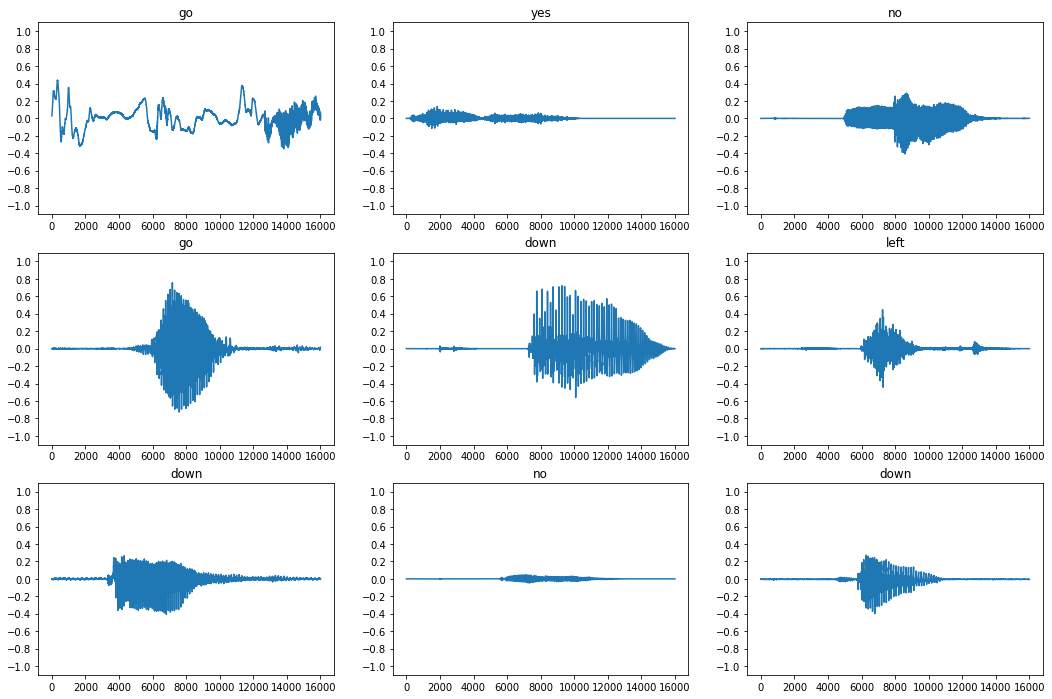

In [10]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 12))

for i in range(n):
    if i>=n:
        break
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(example_audio[i].numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label_names[example_labels[i]]
    ax.set_title(label)
    ax.set_ylim([-1.1,1.1])

plt.show()

## Data Preprocessing
Converting waveforms to **spectograms** (x-axis=time, y-axis=frequency) using **short-time Fourier transform (STFT)**. **Spectograms** which show frequency changes over time and can be represented as 2D images. This spectogram is what will be feed to the neural network model.

A **Fourier transform** (tf.signal.fft) and **STFT** (tf.signal.stft) both converts a signal to its component **frequencies**. The difference is a **Fourier Transform** loses all time information but the **STFT** (**divide the waveforms into multiple windows of time and runs a Fourier Transform** on it) preserving some time information, and returning a 2D tensor that you can run standard convolutions on.
![image.png](https://github.com/marcellinus-witarsah/speech-to-text-model/blob/main/images/spectogram.png?raw=1)

Create a utility function for converting waveforms to spectograms:
1. The waveforms need to be the same length because we want the same length spectogram. If one of the audio waveform length is shorter than the longest length in the data, then it will be padded by 0 filling the remaining length.
2. When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice.
3. The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [11]:
def get_spectrogram(waveform):
    spectogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128,
    )
    spectogram=tf.abs(spectogram)
    spectogram=spectogram[..., tf.newaxis]
    return spectogram

In [12]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Plot spectrogram

In [13]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

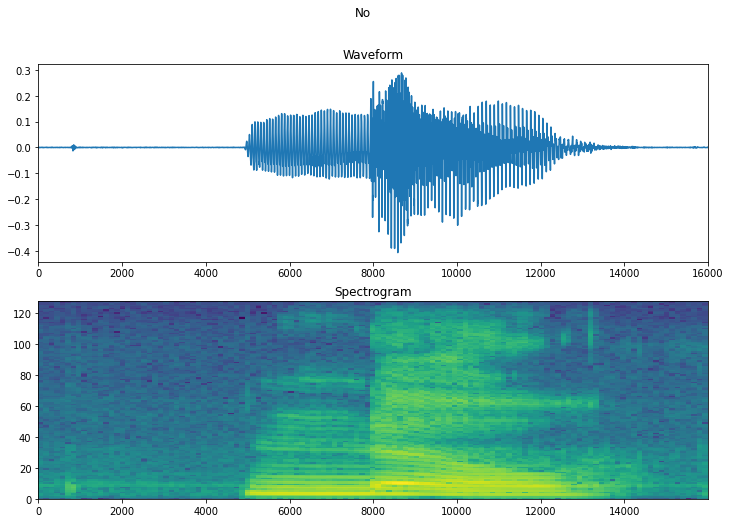

In [14]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Create spectrogram from the audio datasets

In [17]:
def make_spectrogram(ds):
    return ds.map(lambda audio, label: (get_spectrogram(audio), label),
                  num_parallel_calls=config.autotune)

In [18]:
train_spectrogram_ds = make_spectrogram(train_ds)
val_spectrogram_ds = make_spectrogram(val_ds)
test_spectrogram_ds = make_spectrogram(test_ds)


In [19]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

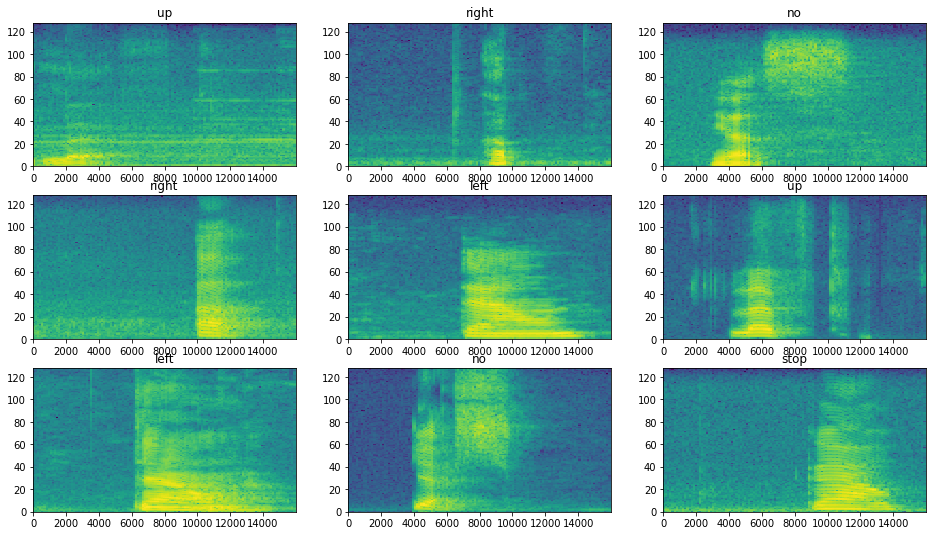

In [20]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(commands[example_spect_labels[i].numpy()])

plt.show()

## Create Model

In [33]:
# prepare data
train_spectrogram_ds = train_spectrogram_ds.shuffle(10000).prefetch(config.autotune)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(config.autotune)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(config.autotune)

In [37]:
# Define input shape
input_shape = example_spectrograms[0].numpy().shape
print("input shape: {}".format(input_shape))
num_labels = len(commands)

# Normalize layer
norm_layer = tf.keras.layers.Normalization()
# Normalizaiton layer according to the data that is available
norm_layer.adapt(data=train_ds.map(lambda spec, label: spec))

# CNN Model
def cnn_model(input_shape):
    return tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        # resize
        tf.keras.layers.Resizing(32, 32),
        # normalize
        norm_layer,
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_labels)
    ])
model = cnn_model(input_shape)
model.summary()

input shape: (124, 129, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_3 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_7 (Normalizat  (None, 32, 32, 16000)    32001     
 ion)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        4608032   
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)       

In [38]:
# compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)],
)

Epoch 1/10
  7/200 [>.............................] - ETA: 1:18:11 - loss: 296.8040 - accuracy: 0.1741